#  Model Training
---

## 0. Constants

In [103]:
TRAIN_DATA_PATH = "../data/processed/train.csv"
TEST_DATA_PATH = "../data/processed/test.csv"

LOG_DATA_DETAILS_PKL    =  "../artifacts/data_details.pkl"
LOG_MODEL_PATH = "../models/model.pkl"
LOG_METRICS_PKL = "../artifacts/metrics.pkl"

---
# 1. Imports

In [51]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="darkgrid", palette="bright")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

In [12]:
train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

## 1.1 Functions

In [3]:
def save_pickle_object(obj, file_path):
    """Serialize Python object as pickle object"""
    
    #create directory if not yet existing
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    #save the object in the file
    with open(file_path, "wb") as file:
        pickle.dump(obj, file)

In [16]:
def evaluate_model(true, predicted):
    """Calculates RMSE & R2 scores of Regression models"""
    
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    
    return rmse, r2_square

---
# 2. Data Processing

In [45]:
#Create X_train, y_train
X_train = train.drop("Weekly_Sales", axis=1)
y_train = train["Weekly_Sales"]

#Create X_test, y_test
X_test = test.drop("Weekly_Sales", axis=1)
y_test = test["Weekly_Sales"]

In [46]:
X_train.shape, X_test.shape

((337256, 17), (84314, 17))

In [47]:
X_train.dtypes

Store             int64
Dept              int64
IsHoliday         int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type              int64
Size              int64
Month             int64
Year              int64
WeekOfYear        int64
dtype: object

In [48]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

---
# 3. Baseline Models

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False)
}

In [27]:
scores = pd.DataFrame()

for i in tqdm(range(len(list(models)))):
    
    #get the model
    model = list(models.values())[i]
    #train the model
    model.fit(X_train, y_train) 

    #make predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #evaluate Train and Test dataset
    rmse_train, r2_train = evaluate_model(y_train, pred_train)
    rmse_test, r2_test = evaluate_model(y_test, pred_test)
    
    #create a series of scores
    model_scores = pd.Series([rmse_train, rmse_test, r2_train, r2_test], 
                             name=f"{list(models.keys())[i]}", 
                             index=["RMSE-train", "RMSE-test", "R2-train", "R2-test"])
    
    scores = pd.concat([scores ,model_scores], axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:12<00:00, 153.21s/it]


In [29]:
scores.T

,RMSE-train,RMSE-test,R2-train,R2-test
Linear Regression,21710.989502,21686.443821,0.086877,0.085239
Random Forest Regressor,1447.128539,4301.789024,0.995943,0.964006
XGBRegressor,5135.445175,5638.198791,0.948911,0.938168
CatBoosting Regressor,5573.157575,5897.189621,0.939831,0.932357


>**Random Forrest Regreseor performed the best as a baseline model. XGBregressor & Catboosting Regressor performance were high close & Random Forrest, hence we will explore them more with Hyperparameter Tuning throuhg `GridSearchCV`**

### Feature importances

In [31]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train) 

RandomForestRegressor()

In [35]:
cols = train.drop("Weekly_Sales", axis=1).columns.tolist()

In [38]:
features_importance = pd.Series(rf.feature_importances_, name="Features Importance", index=cols).to_frame()
features_importance = features_importance.sort_values(by="Features Importance", ascending=False)

features_importance

,Features Importance
Dept,0.625050
Size,0.205642
Store,0.061569
WeekOfYear,0.040118
Type,0.014573
CPI,0.009843
Month,0.007242
Temperature,0.006603
Unemployment,0.005540
MarkDown3,0.004047


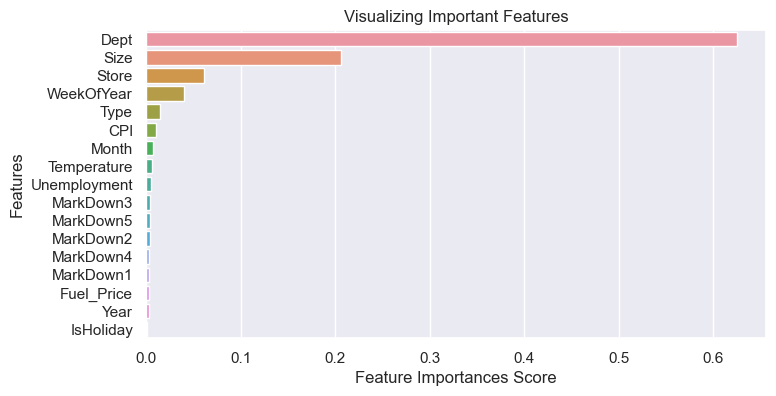

In [96]:
#plot the feature importances
plt.figure(figsize=(8,4))
sns.barplot(data = features_importance, x="Features Importance", y=features_importance.index)
plt.xlabel('Feature Importances Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

---
## 4. Model 1: Random Forest Regressor + Top 5 Features

In [50]:
#Use top 5 features for predictions
X_train_top5 = X_train[features_importance.index[:5]]
X_test_top5 = X_test[features_importance.index[:5]]

In [52]:
rf2 = RandomForestRegressor()
rf2.fit(X_train_top5, y_train) 

RandomForestRegressor()

In [55]:
#make predictions
pred_train = rf2.predict(X_train_top5)
pred_test = rf2.predict(X_test_top5)

#evaluate Train and Test dataset
rmse_train, r2_train = evaluate_model(y_train, pred_train)
rmse_test, r2_test = evaluate_model(y_test, pred_test)

#create a series of scores
rf2_model_scores = pd.Series([rmse_train, rmse_test, r2_train, r2_test], 
                            name="RandomForest Regressor 2", 
                            index=["RMSE-train", "RMSE-test", "R2-train", "R2-test"]).to_frame().T
rf2_model_scores

,RMSE-train,RMSE-test,R2-train,R2-test
RandomForest Regressor 2,2456.24915,4010.915387,0.988313,0.968709


## 4.1 Hyperparameter Tuning

In [67]:
rf_params={
    'n_estimators': [50,100,200],
    'max_depth':[2,4,None],
    'max_features':['sqrt',None]
}

In [68]:
#create rf3 model
rf3 = RandomForestRegressor()
#create GridSearchCV
grid_search = GridSearchCV(rf3, param_grid=rf_params, cv=3, n_jobs=-1)
#fit the model
grid_search.fit(X_train, y_train)

C:\Users\MR\anaconda3\envs\PyTorch-CUDA118\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\MR\anaconda3\envs\PyTorch-CUDA118\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\MR\anaconda3\envs\PyTorch-CUDA118\lib\site-packages\sklearn\ensemble\_forest.py", line 473, in fit
    trees = Parallel(
  File "C:\Users\MR\anaconda3\envs\PyTorch-CUDA118\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, None],
                         'max_features': ['sqrt', None],
                         'n_estimators': [50, 100, 200]})

In [69]:
#get the best model from the GridSearchCV
gs1_best_model = grid_search.best_estimator_

#get predictions for train & test data
pred_train = gs1_best_model.predict(X_train)
pred_test = gs1_best_model.predict(X_test)

#evaluate Train and Test dataset
rmse_train, r2_train = evaluate_model(y_train, pred_train)
rmse_test, r2_test = evaluate_model(y_test, pred_test)

#create a series of scores
rf3_model_scores = pd.Series([rmse_train, rmse_test, r2_train, r2_test], 
                            name="RandomForest Regressor 3", 
                            index=["RMSE-train", "RMSE-test", "R2-train", "R2-test"]).to_frame().T

In [71]:
#print best estimator
print("Best Model with parameters is:\n", gs1_best_model)

#print score results
rf3_model_scores

Best Model with parameters is:
 RandomForestRegressor(max_depth=4, max_features=None, n_estimators=50)


,RMSE-train,RMSE-test,R2-train,R2-test
RandomForest Regressor 3,16832.179531,16816.263931,0.451154,0.449966


---
## 5. Model 2: XGBRegressor + Top 5 Features

In [74]:
xgb1 = XGBRegressor()
xgb1.fit(X_train_top5, y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [75]:
#make predictions
pred_train = xgb1.predict(X_train_top5)
pred_test = xgb1.predict(X_test_top5)

#evaluate Train and Test dataset
rmse_train, r2_train = evaluate_model(y_train, pred_train)
rmse_test, r2_test = evaluate_model(y_test, pred_test)

#create a series of scores
xgb1_model_scores = pd.Series([rmse_train, rmse_test, r2_train, r2_test], 
                            name="XGBoost Regressor 1", 
                            index=["RMSE-train", "RMSE-test", "R2-train", "R2-test"]).to_frame().T
xgb1_model_scores

,RMSE-train,RMSE-test,R2-train,R2-test
XGBoost Regressor 1,5089.963565,5376.719029,0.949812,0.94377


## 5.1 Hyperparameter Tuning: Using top 5 features

In [76]:
xgb_params={
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 500, 1000]
}

In [77]:
#create xgb2 model
xgb2 = XGBRegressor()
#create GridSearchCV
grid_search = GridSearchCV(xgb2, param_grid=xgb_params, cv=3, n_jobs=-1)
#fit the model on top 5 features
grid_search.fit(X_train_top5, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]})

In [81]:
#get the best model from the GridSearchCV
gs2_best_model = grid_search.best_estimator_

#get predictions for train & test data
pred_train = gs2_best_model.predict(X_train_top5)
pred_test = gs2_best_model.predict(X_test[features_importance.index[:5]])

#evaluate Train and Test dataset
rmse_train, r2_train = evaluate_model(y_train, pred_train)
rmse_test, r2_test = evaluate_model(y_test, pred_test)

#create a series of scores
xgb2_model_scores = pd.Series([rmse_train, rmse_test, r2_train, r2_test], 
                            name="XGBoost Regressor 2", 
                            index=["RMSE-train", "RMSE-test", "R2-train", "R2-test"]).to_frame().T

In [84]:
#print best estimator
print("Best Model with parameters is:\n", gs2_best_model)

#print score results
xgb2_model_scores

Best Model with parameters is:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


,RMSE-train,RMSE-test,R2-train,R2-test
XGBoost Regressor 2,3122.85421,3572.338821,0.981108,0.975178


## 5.2 Hyperparameter Tuning: Using all features

In [97]:
#create xgb2 model
xgb3 = XGBRegressor()
#create GridSearchCV
grid_search = GridSearchCV(xgb3, param_grid=xgb_params, cv=3, n_jobs=-1)
#fit the model on all features
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]})

In [98]:
#get the best model from the GridSearchCV
gs3_best_model = grid_search.best_estimator_

#get predictions for train & test data
pred_train = gs3_best_model.predict(X_train)
pred_test = gs3_best_model.predict(X_test)

#evaluate Train and Test dataset
rmse_train, r2_train = evaluate_model(y_train, pred_train)
rmse_test, r2_test = evaluate_model(y_test, pred_test)

#create a series of scores
xgb3_model_scores = pd.Series([rmse_train, rmse_test, r2_train, r2_test], 
                            name="XGBoost Regressor 3", 
                            index=["RMSE-train", "RMSE-test", "R2-train", "R2-test"]).to_frame().T

In [99]:
#print best estimator
print("Best Model with parameters is:\n", gs3_best_model)

#print score results
xgb3_model_scores

Best Model with parameters is:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


,RMSE-train,RMSE-test,R2-train,R2-test
XGBoost Regressor 3,3108.346273,4332.997234,0.981283,0.963482


---
## 6. Models Comparison

In [100]:
final_scores = pd.concat([rf2_model_scores, rf3_model_scores, xgb1_model_scores, xgb2_model_scores, xgb3_model_scores], 
                                   axis=0)
final_scores

,RMSE-train,RMSE-test,R2-train,R2-test
RandomForest Regressor 2,2456.249150,4010.915387,0.988313,0.968709
RandomForest Regressor 3,16832.179531,16816.263931,0.451154,0.449966
XGBoost Regressor 1,5089.963565,5376.719029,0.949812,0.943770
XGBoost Regressor 2,3122.854210,3572.338821,0.981108,0.975178
XGBoost Regressor 3,3108.346273,4332.997234,0.981283,0.963482


---
## 7. Log Data details & Model

In [90]:
# save_pickle_object(gs2_best_model, MODEL_PATH)

In [101]:
top_5_features = list(features_importance.index[:5])

In [109]:
y_train.name

'Weekly_Sales'

In [108]:
X_train.columns.tolist()

['Store',
 'Dept',
 'IsHoliday',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Type',
 'Size',
 'Month',
 'Year',
 'WeekOfYear']

In [114]:
# Data details
data_details = {"train_data_path": TRAIN_DATA_PATH,
                "test_data_path":  TEST_DATA_PATH,
#                 "training_indices": X_train.index.tolist(),
#                 "test_indices":     X_test.index.tolist(), 
                "features_names":  X_train.columns.tolist(),
                "top_5_features":  top_5_features, 
                "target_name":   y_train.name}

save_pickle_object(data_details, LOG_DATA_DETAILS_PKL)

In [115]:
# Model
model = {"model_description": "XGBRegressor + Hyperparamter tuning",
         "model_details": str(gs3_best_model),
         "model_object": gs3_best_model} 

save_pickle_object(model, LOG_MODEL_PATH)